<a href="https://colab.research.google.com/github/sayakpaul/E2E-Object-Detection-in-TFLite/blob/master/Object_Detection_in_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!pip install -q tf-nightly

     |████████████████████████████████| 389.9MB 42kB/s 
     |████████████████████████████████| 460kB 46.8MB/s 
     |████████████████████████████████| 9.2MB 45.1MB/s 


In [ ]:
import tensorflow as tf 
print(tf.__version__)

2.4.0-dev20200909


In [ ]:
!git clone https://github.com/tensorflow/models.git

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

You can ignore the compatibility errors.

**Optionally** run the following. 

In [ ]:
# !python models/research/object_detection/builders/model_builder_tf2_test.py

In [ ]:
# Other imports
import matplotlib
import matplotlib.pyplot as plt

import cv2
import time
import numpy as np

from PIL import Image

## Export a TFLite compatible model graph

Training notebook is available [here](https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Training_a_pets_detector_model_within_minutes_with_TFOD_API.ipynb). The training was done on the pets dataset. The checkpoint files are coming from a **public** GCS bucket. 

In [ ]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [ ]:
!python /content/models/research/object_detection/export_tflite_graph_tf2.py \
    --trained_checkpoint_dir gs://pet_detector_tf2/pets_detector \
    --output_directory `pwd` \
    --pipeline_config_path gs://pet_detector_tf2/data/pets_detector.config

In [ ]:
!ls -lh /content/saved_model/

total 6.4M
drwxr-xr-x 2 root root 4.0K Sep  9 14:51 assets
-rw-r--r-- 1 root root 6.4M Sep  9 14:51 saved_model.pb
drwxr-xr-x 2 root root 4.0K Sep  9 14:51 variables


## Convert to TensorFlow Lite

For this purpose, we will be using the dynamic-range post-training quantization to keep things simple. You can check out all the post-training quantization recipes available with TFLite [here](https://www.tensorflow.org/lite/performance/post_training_quantization). 

In [ ]:
# Convert the model to TF lite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model/')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Serialize the model
open('pets_detector.tflite', 'wb').write(tflite_model)

5711632

In [ ]:
!ls -lh pets_detector.tflite

-rw-r--r-- 1 root root 5.5M Sep  9 14:52 pets_detector.tflite


## Run inference with the TFLite model

In [ ]:
#@title TFLite Interpreter and detection utils 
#@markdown Sourced from [here](https://github.com/tensorflow/examples/blob/master/lite/examples/object_detection/raspberry_pi/detect_picamera.py).

def set_input_tensor(interpreter, image):
  """Sets the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Returns the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all output details
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
          'bounding_box': boxes[i],
          'class_id': classes[i],
          'score': scores[i]
      }
      results.append(result)
  return results

def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all output details
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
          'bounding_box': boxes[i],
          'class_id': classes[i],
          'score': scores[i]
      }
      results.append(result)
  return results

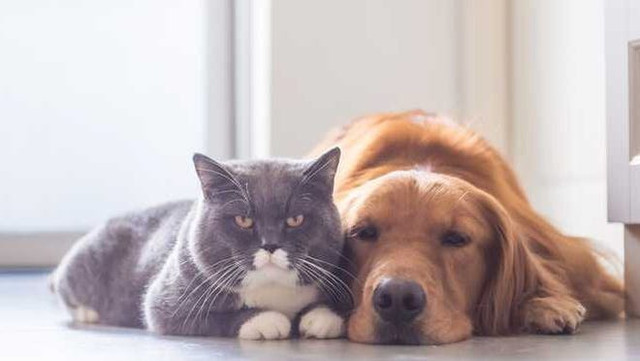

In [ ]:
#@title Supply a path to download a relevant image
IMAGE_PATH = "https://i.ibb.co/Bw5bSt1/Motley-Fool-TMOT-816b1ceb-0ece06e3.jpg" #@param {type:"string"}

!wget -q -O image.png $IMAGE_PATH
Image.open('image.png')

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/pets_detector.tflite")
interpreter.allocate_tensors()
_, HEIGHT, WIDTH, _ = interpreter.get_input_details()[0]['shape']
print(f"Height and width accepted by the model: {HEIGHT, WIDTH}")

Height and width accepted by the model: (300, 300)


In [ ]:
#@title Image preprocessing utils
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    original_image = img
    resized_img = tf.image.resize(img, (HEIGHT, WIDTH))
    resized_img = resized_img[tf.newaxis, :]
    return resized_img, original_image

In [ ]:
#@title Define the label dictionary and color map
LABEL_DICT = {1: 'Abyssinian',
    2: 'american_bulldog',
    3: 'american_pit_bull_terrier',
    4: 'basset_hound',
    5: 'beagle',
    6: 'Bengal',
    7: 'Birman',
    8: 'Bombay',
    9: 'boxer',
    10: 'British_Shorthair',
    11: 'chihuahua',
    12: 'Egyptian_Mau',
    13: 'english_cocker_spaniel',
    14: 'english_setter',
    15: 'german_shorthaired',
    16: 'great_pyrenees',
    17: 'havanese',
    18: 'japanese_chin',
    19: 'keeshond',
    20: 'leonberger',
    21: 'Maine_Coon',
    22: 'miniature_pinscher',
    23: 'newfoundland',
    24: 'Persian',
    25: 'pomeranian',
    26: 'pug',
    27: 'Ragdoll',
    28: 'Russian_Blue',
    29: 'saint_bernard',
    30: 'samoyed',
    31: 'scottish_terrier',
    32: 'shiba_inu',
    33: 'Siamese',
    34: 'Sphynx',
    35: 'staffordshire_bull_terrier',
    36: 'wheaten_terrier',
    37: 'yorkshire_terrier'
}

COLORS = np.random.randint(0, 255, size=(len(LABEL_DICT), 3), 
                            dtype="uint8")

In [ ]:
#@title Inference utils
def display_results(image_path):
    # Load the input image and preprocess it
    preprocessed_image, original_image = preprocess_image(image_path)
    # print(preprocessed_image.shape, original_image.shape)

    # =============Perform inference=====================
    start_time = time.monotonic()
    results = detect_objects(interpreter, preprocessed_image, threshold=0.3)
    print(f"Elapsed time: {(time.monotonic() - start_time)*1000} miliseconds")

    # =============Display the results====================
    original_numpy = original_image.numpy()
    for obj in results:
        # Convert the bounding box figures from relative coordinates
        # to absolute coordinates based on the original resolution
        ymin, xmin, ymax, xmax = obj['bounding_box']
        xmin = int(xmin * original_numpy.shape[1])
        xmax = int(xmax * original_numpy.shape[1])
        ymin = int(ymin * original_numpy.shape[0])
        ymax = int(ymax * original_numpy.shape[0])

        # Grab the class index for the current iteration
        idx = int(obj['class_id'])
        # Skip the background
        if idx >= len(LABEL_DICT):
            continue

        # Draw the bounding box and label on the image
        color = [int(c) for c in COLORS[idx]]
        cv2.rectangle(original_numpy, (xmin, ymin), (xmax, ymax), 
                    color, 2)
        y = ymin - 15 if ymin - 15 > 15 else ymin + 15
        label = "{}: {:.2f}%".format(LABEL_DICT[obj['class_id']],
            obj['score'] * 100)
        cv2.putText(original_numpy, label, (xmin, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Return the final image
    original_int = (original_numpy * 255).astype(np.uint8)
    return original_int

Elapsed time: 2142.712570000185 miliseconds


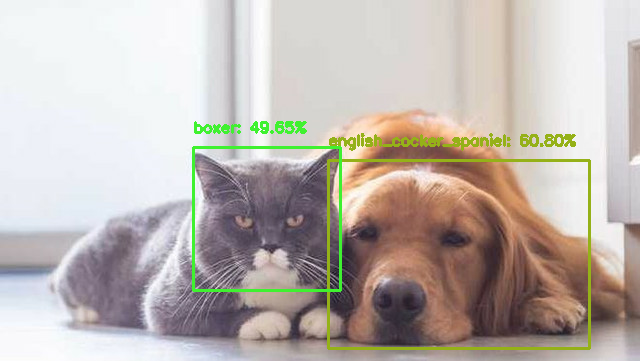

In [ ]:
resultant_image = display_results("image.png")
Image.fromarray(resultant_image)

[This example](https://github.com/tensorflow/examples/blob/master/lite/examples/object_detection/raspberry_pi) provides a utility for running a similar TFLite model on real-time video feeds. 